In [1]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import time
import os
import missingno as msno
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.cluster import adjusted_rand_score

In [8]:
#RFM_dt = pd.read_csv('df_rfm_date.csv')
#df_cmd = pd.read_csv('commandes_dataset.csv')
RFM_score_review=pd.read_csv('df_rfm_date_score.csv')

In [9]:
RFM_score_review.head()

,customer_unique_id,Frequency,Recency,Monetary,last_purshase_date,favorite_purshase_month,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,2018-05-10 10:56:27,May,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,2018-05-07 11:11:27,May,4.0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,2017-03-10 21:05:03,March,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,2017-10-12 20:29:41,October,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,2017-11-14 19:45:42,November,5.0


In [10]:
RFM_score_review['last_purshase_date']=pd.to_datetime(RFM_score_review['last_purshase_date'])

In [12]:
RFM_score_review.dtypes

customer_unique_id                 object
Frequency                           int64
Recency                             int64
Monetary                          float64
last_purshase_date         datetime64[ns]
favorite_purshase_month            object
review_score_mean                 float64
dtype: object

In [13]:
period_days_dataset = RFM_score_review['last_purshase_date'].max()-RFM_score_review['last_purshase_date'].min()
print(
    f"La période complète des commandes porte sur {period_days_dataset} jours")
period_months_dataset = round(period_days_dataset / np.timedelta64(1, 'M'))
print("La période complète des commandes porte sur {} mois.".format(
    period_months_dataset))

La période complète des commandes porte sur 694 days 22:03:47 jours
La période complète des commandes porte sur 23 mois.


In [14]:
RFM_date=RFM_score_review.copy()

In [15]:
def fmake_data(dm, period, initial=False):
    '''
    initial:boolean
            indique si  le datset est l'initial
    period:int
           indique la période d'incrémentation en mois après le dataset initial
    dm:string
       indique si on va prendre la période en jours ou mois .Il prend deux valeurs:day,month()

    '''
    #RFM_date['last_purshase_date'] = pd.to_datetime(        RFM_date.last_purshase_date)
    if dm == 'day':
        if initial == True:
            period = 365  # 12mois=365jours
        else:
            period = 365+period
        stop = RFM_date.last_purshase_date.min()+pd.DateOffset(days=int(period))
    elif dm == 'month':
        if initial == True:
            period = 12  # 12mois
        else:
            period = 12+period
        stop = RFM_date.last_purshase_date.min()+pd.DateOffset(months=int(period))

    start = RFM_date.last_purshase_date.min()
    # stop=RFM_date.last_purshase_date.min()+pd.DateOffset(days=int(period))
    # stop=start+pd.DateOffset(days=int(period))
    print('Début de la période:', start)
    print('Fin de la période:', stop)
    data = RFM_date[(RFM_date['last_purshase_date'] >= start)
                    & (RFM_date['last_purshase_date'] < stop)]

    print('shape', data.shape)
    print(50*'-')
    return (data)

In [16]:
def compute_ari_score(rang, dm, data_init, k, init_labels):
    '''
    This function aims at computing the ari score
    rang:int
    '''
    ari_score = []
    for p in rang:
        # Create dataset for period
        print(p)
        data_period = fmake_data(dm, period=p, initial=False)
        #data_period = data_period[['Frequency', 'Recency', 'Monetary']]
        data_period = data_period[['Frequency', 'Recency', 'Monetary','review_score_mean']]
        # K-Means
        kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                             ("kmeans", KMeans(k))])
        kmeans_p.fit(data_period)
        p_labels = kmeans_p.named_steps['kmeans'].labels_
        # Filter on initial customer client
        list_init = data_init.index
        mask = data_period.index.isin(list_init)
        clusters_new = kmeans_p.named_steps['kmeans'].labels_[mask]
        print(len(clusters_new))
        print(mask)
        print('init label', init_labels)
        print('predicted label', p_labels)
        # Calculate ARI score
        ari_p = adjusted_rand_score(init_labels, clusters_new)
        print(ari_p)
        ari_score.append([p, ari_p])
    return (ari_score)

In [17]:
def plot_ari_score(ari_score, xlabe, rg):
    %matplotlib notebook
    ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

    # plot ARI Score
    fig = plt.figure(figsize=(12, 8))
    sns.lineplot(data=ari_score, x="periode", y="ARI")
    plt.xticks(rg)
    plt.xlabel(xlabe)
    plt.ylabel("Score ARI")

    plt.title("Stabilité temporelle de la segmentation par K-Means",
              fontsize=18,
              color="b")
    plt.show()

#### Période en jours

In [18]:
data_ini_d = fmake_data('day', period=15, initial=True)
data_init_d = data_ini_d[['Frequency', 'Recency', 'Monetary','review_score_mean']]

kmeans_init_d = Pipeline([("preprocessor", StandardScaler()),
                          ("kmeans", KMeans(5))])
kmeans_init_d.fit(data_init_d)
init_labels_d = kmeans_init_d.named_steps['kmeans'].labels_

Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 7)
--------------------------------------------------


In [19]:
nb_days = round(period_days_dataset / np.timedelta64(1, 'D'))
step_days = 7
range_days = np.arange(0, (nb_days-365), step_days)
ari_score1 = compute_ari_score(
    range_days, 'day', data_init_d, 5, init_labels_d)

0
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 7)
--------------------------------------------------
24798
[ True  True  True ...  True  True  True]
init label [4 4 3 ... 1 4 4]
predicted label [0 0 2 ... 4 0 0]
0.9838159989379259
7
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-10 16:56:50
shape (25732, 7)
--------------------------------------------------
24798
[ True  True  True ...  True  True  True]
init label [4 4 3 ... 1 4 4]
predicted label [1 1 4 ... 3 1 1]
0.9454322207229685
14
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-17 16:56:50
shape (26721, 7)
--------------------------------------------------
24798
[ True False  True ...  True  True  True]
init label [4 4 3 ... 1 4 4]
predicted label [1 0 1 ... 4 1 1]
0.901319004389678
21
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-24 16:56:50
shape (27716, 7)
--------------------------------------------------
24798
[ T

24798
[ True False False ... False  True  True]
init label [4 4 3 ... 1 4 4]
predicted label [3 1 1 ... 1 3 3]
0.2633812873910678
210
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-05-01 16:56:50
shape (66815, 7)
--------------------------------------------------
24798
[ True False False ... False  True  True]
init label [4 4 3 ... 1 4 4]
predicted label [4 0 0 ... 0 4 4]
0.27615253991641725
217
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-05-08 16:56:50
shape (68668, 7)
--------------------------------------------------
24798
[False  True False ...  True False  True]
init label [4 4 3 ... 1 4 4]
predicted label [1 2 1 ... 2 1 2]
0.282105748289591
224
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-05-15 16:56:50
shape (70584, 7)
--------------------------------------------------
24798
[False False  True ...  True False  True]
init label [4 4 3 ... 1 4 4]
predicted label [0 0 1 ... 1 0 1]
0.283735850740128
231
Début de la période: 

<IPython.core.display.Javascript object>


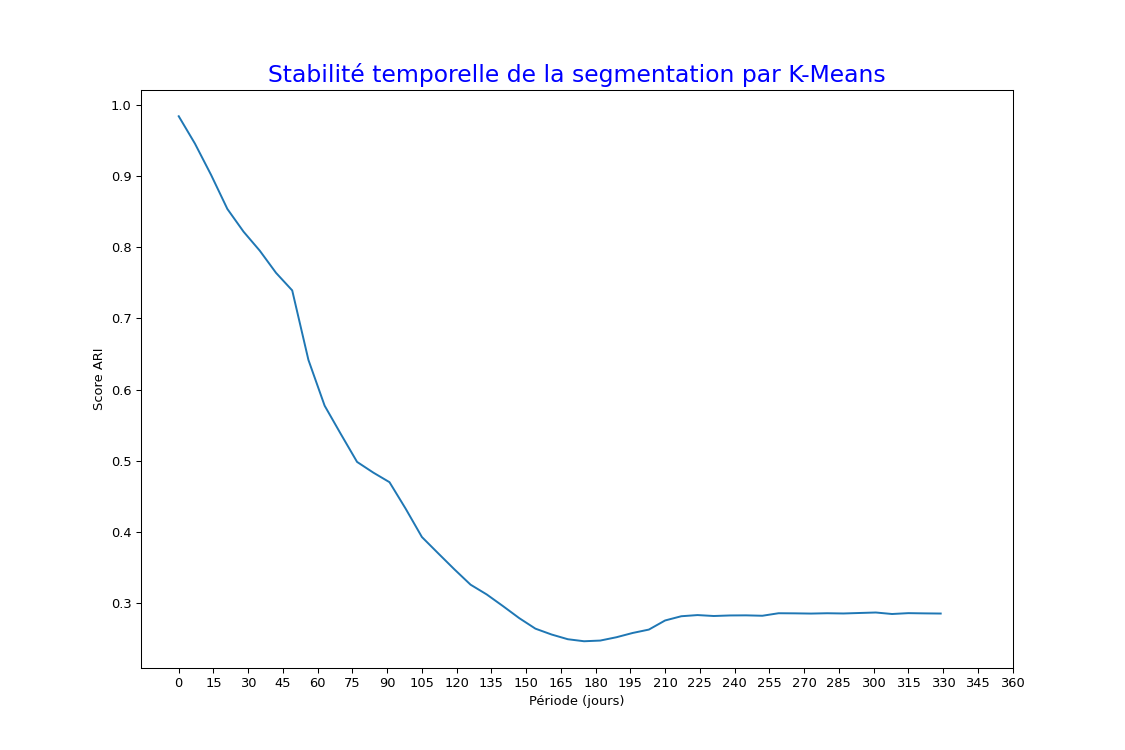

In [24]:
plot_ari_score(ari_score1, "Période (jours)", np.arange(0, 365, step=15))

#### Période en mois

In [21]:
data_init_m = fmake_data('month', period=15, initial=True)
data_init_m = data_init_m[['Frequency', 'Recency', 'Monetary','review_score_mean']]

kmeans_init_m = Pipeline([("preprocessor", StandardScaler()),
                          ("kmeans", KMeans(5))])
kmeans_init_m.fit(data_init_m)
init_labels_m = kmeans_init_m.named_steps['kmeans'].labels_

Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 7)
--------------------------------------------------


In [22]:
pas = 1
range_months = np.arange(0, (period_months_dataset-12), pas)
ari_score2 = compute_ari_score(
    range_months, 'month', data_init_m, 5, init_labels_m)

0
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-10-03 16:56:50
shape (24798, 7)
--------------------------------------------------
24798
[ True  True  True ...  True  True  True]
init label [2 2 0 ... 3 2 2]
predicted label [1 1 0 ... 2 1 1]
0.9988279277149423
1
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-11-03 16:56:50
shape (28956, 7)
--------------------------------------------------
24798
[ True False  True ...  True  True  True]
init label [2 2 0 ... 3 2 2]
predicted label [4 2 4 ... 0 4 4]
0.8062809544086629
2
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2017-12-03 16:56:50
shape (36096, 7)
--------------------------------------------------
24798
[ True False False ...  True  True  True]
init label [2 2 0 ... 3 2 2]
predicted label [0 2 2 ... 4 0 0]
0.6085331230644834
3
Début de la période: 2016-10-03 16:56:50
Fin de la période: 2018-01-03 16:56:50
shape (41089, 7)
--------------------------------------------------
24798
[ Tr

<IPython.core.display.Javascript object>


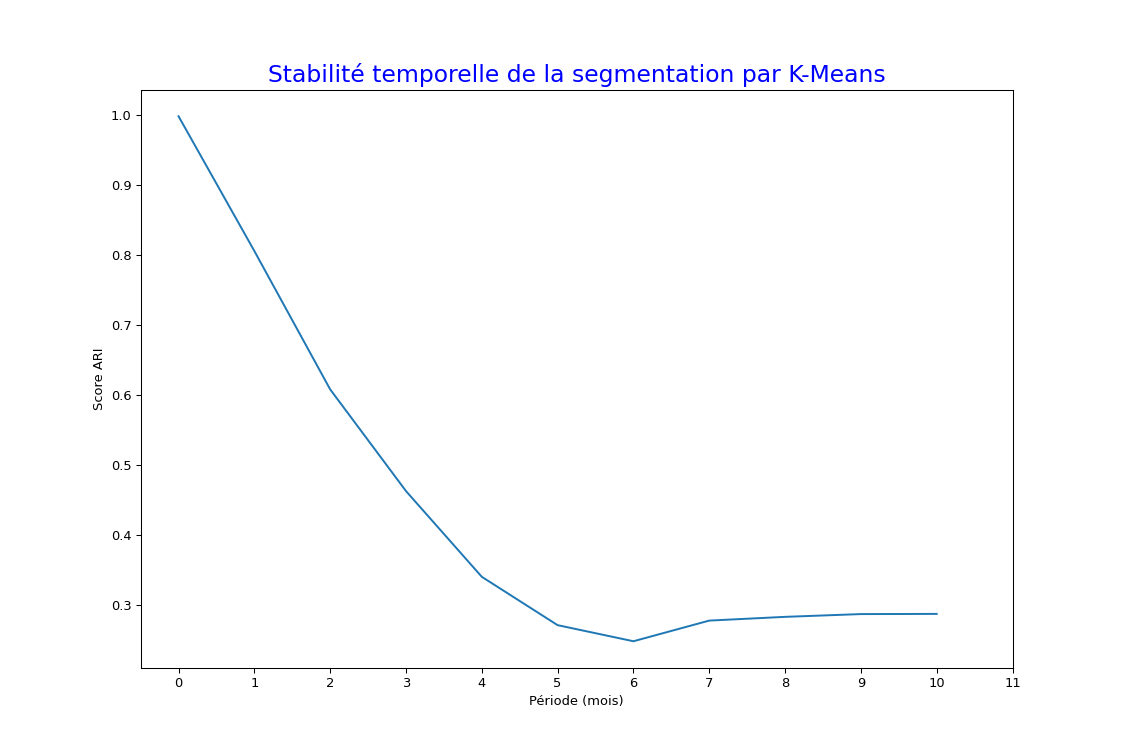

In [23]:
plot_ari_score(ari_score2, "Période (mois)", np.arange(0, 12, step=1))